# Задание 1 [2 балла]
#### Средствами matplotlib напишите код, который один-в-один воспроизведет данное изображение.
##### 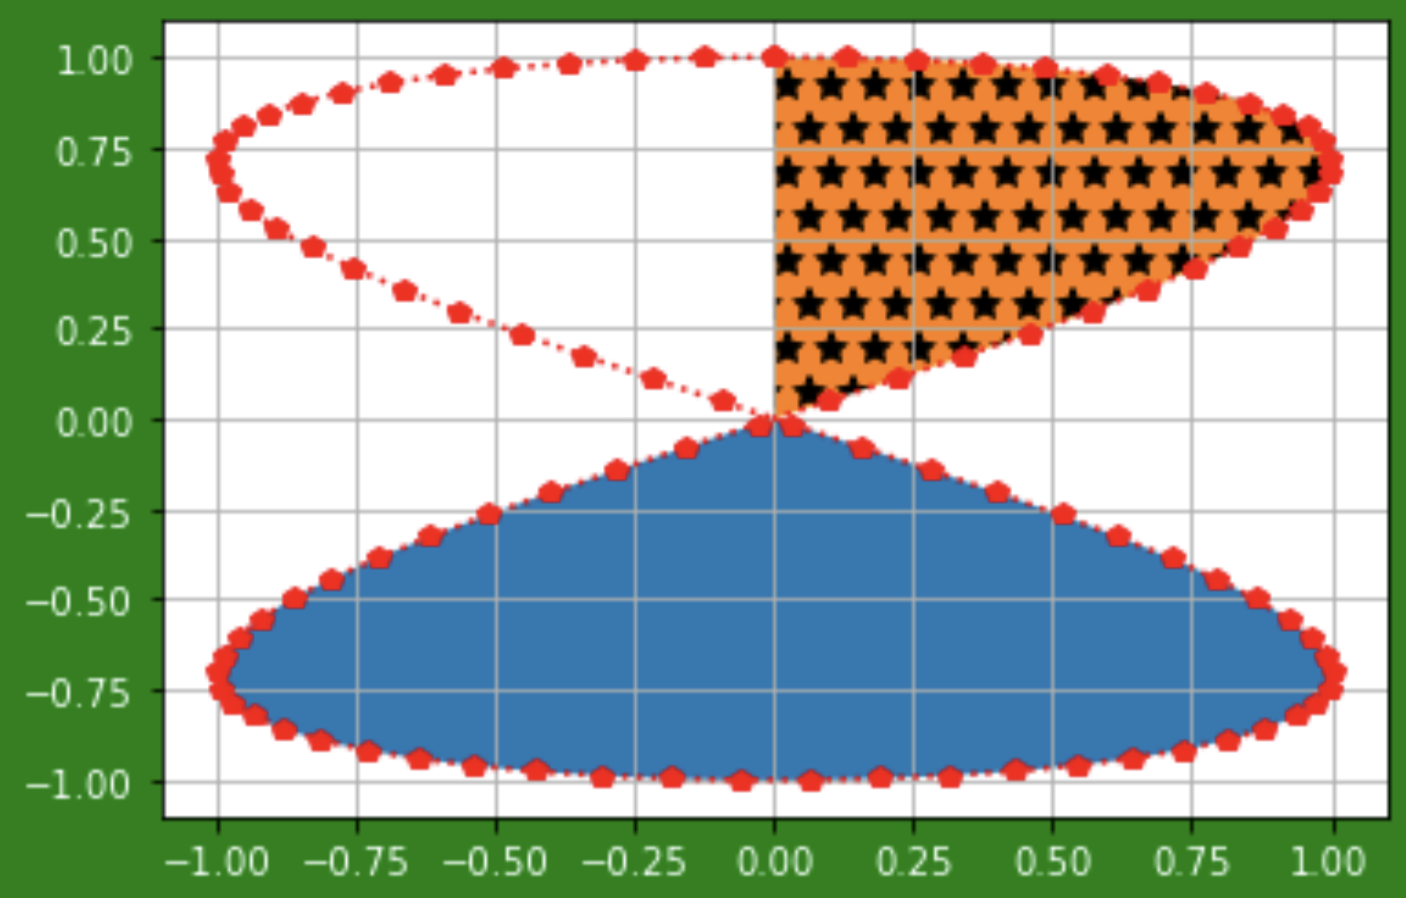

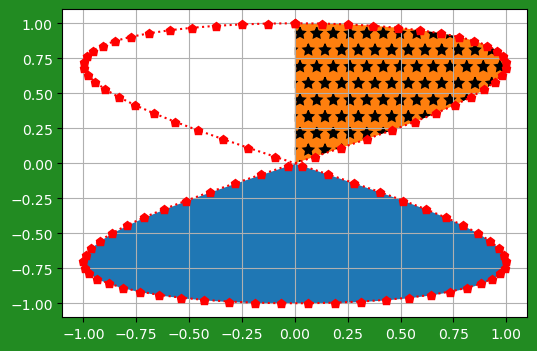

In [1]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot()

x = np.linspace(0, 2*np.pi, 100)
fig.set_size_inches(6, 4) # задаем ширину как как на оригинале
fig.patch.set_facecolor('forestgreen') # цвет внешней части графика
ax.tick_params(labelcolor='white') # цвет подписей делений

# Рисуем фигуру точками и ставим маркер как на оригинале
plt.plot(np.sin(2*x), np.sin(x + np.pi/2), ':', marker='p', markersize=6.3, color='red') 
# Закрашиваем нижнюю часть
plt.fill_between(np.sin(x), np.sin(x/2 + np.pi), color='tab:blue', lw=0) 
# Закрашиваем верхнюю часть и заполняем *
plt.fill_between(np.sin(x/2), np.sin(x/4), color='tab:orange', hatch="*", edgecolor='black', lw=0)
plt.grid()
plt.show()

# Задание 2 [3 балла]
#### Напишите функцию, которая осуществляет SQL запросы над pandas-dataframe. Протестируйте ее на предложенном наборе данных

In [1]:
import pandas as pd
import scipy.stats as sps
d1 = {'one': pd.Series(range(6), index=list('abcdef')),
     'two': pd.Series(range(7), index=list('abcdefg')),
     'three': pd.Series(sps.norm.rvs(size=7), index=list('abcdefg'))}
df1 = pd.DataFrame(d1).reset_index()
df1

,index,one,two,three
0,a,0.0,0,0.596666
1,b,1.0,1,-1.551196
2,c,2.0,2,-1.552095
3,d,3.0,3,0.862451
4,e,4.0,4,0.007995
5,f,5.0,5,-1.203208
6,g,NaN,6,-1.311957


In [3]:
import pandas as pd
import scipy.stats as sps
d2 = {'second_index': pd.Series(['a', 'b', 'd', 'c', 'd', 'c', 'k', 'l']),
     'four': pd.Series(range(10, 18)),
     'five': pd.Series(sps.norm.rvs(size=8))}
df2 = pd.DataFrame(d2)
df2

,second_index,four,five
0,a,10,-0.859846
1,b,11,-1.312993
2,d,12,0.406040
3,c,13,-0.919658
4,d,14,1.825534
5,c,15,-2.499664
6,k,16,1.420862
7,l,17,-0.723657


### Пример формата запроса:

SELECT tab1.column1 as c1, tab2.column2 as c2, tab1.column1+tab2.column2 as sum12
FROM tab1 RIGHT JOIN tab2 ON tab1.ind1=tab2.ind2
WHERE tab2.four>5 ORDER BY tab2.column3 ASC, tab1.column4 DESC

Реализовать какой-то больший функционал, чем указан в примере запроса не нужно. Общий функционал: новые имена столбцов, арифметические операции на столбцах, объединение таблиц (не только правое!), фильтр по условию, сортировка.

Чтобы легче было парсить, считаем, что пользователь всегда пишет запрос красиво и корректно (как в примере).

In [4]:
query = \
"""
SELECT df1.one as c1, df2.five as c2, df1.three+df2.four as sum12
FROM df1 JOIN df2 ON tab1.index=tab2.second_index
WHERE df1.one>=2
ORDER BY df2.five ASC
"""

In [5]:
tab_dict = {'df1': df1, 'df2': df2}

In [6]:
# Удаляем имя таблицы и добавляем одиночные кавычки при q==1
def del_tbl(str,q=0):
    s = str
    res = s[s.find(".")+1:]
    if q == 1:
        res = "'" + res + "'"
    return res

def SQL_query(query, tab_dict):
    mq = query
    # Добавляем пробелы чтобы разделить все SQL-элементы
    for sign in ("+" "-" "*" "/" "," "=" ">" "<"):
        mq = mq.replace(sign, " " + sign + " ")
        
    # Множественные пробелы приводим к одиночному
    mq=" ".join(mq.split())
    
    # Удаляем пробелы внутри логических операторов
    mq=mq.replace("> =",">=")    
    mq=mq.replace("< =","<=")    
    mq=mq.replace("< >","<>")    
    mq=mq.replace("! =","!=")    
 
    # Разделяем выражение на отдельные слова
    sqlword = mq.split()
    
    # Получаем имена таблиц (1 и 2)
    i = sqlword.index("FROM")
    tab1 = sqlword[i+1]
    i = sqlword.index("ON")
    tab2 = sqlword[i-1]

    # Индексы для операции JOIN
    left_on = del_tbl(sqlword[i+1],1)
    right_on = del_tbl(sqlword[i+3],1)
    
    # Конструируем условие из оператора WHERE
    # Действует ограничение: все условия должны относиться только к одной из двух таблиц (либо df1, либо df2)
    t = ""
    wcond = ""
    i = sqlword.index("WHERE") + 1
    while sqlword[i] != "ORDER":
        s = sqlword[i]
        if s.find(tab1) == 0:
            # Условие относится к первой таблице
            t = tab1 
            wcond = wcond + s
        elif s.find(tab2) == 0:
            # Условие относится ко второй таблице
            t = tab2 
            wcond = wcond + s
        elif s == "OR":
            wcond = wcond + ")|("
        elif s == "AND":
            wcond = wcond + ")&("
        elif s == "<>":
            # Устаревший вариант "не равно" меняем на стандартный
            wcond = wcond + "!=" 
        else:
            wcond = wcond + s
        i += 1
    if t == tab1:
        tab1 = tab1 + "[(" + wcond + ")]"
    elif t == tab2:
        tab2 = tab2 + "[(" + wcond + ")]"
    
    # Обрабатываеи операторы сортировки ORDER BY
    sort_vals=list()
    asc_order=list()
    
    # Начинаем парсинг сразу после "BY"
    i = sqlword.index("BY") + 1 
    while i != len(sqlword):
        s = sqlword[i]
        if (s != ",") & (s != "DESC") & (s != "ASC"):
            sort_vals.append(del_tbl(s,1))
            # Сортировка по умолчанию
            asc_order.append('True') 
        elif s == "DESC":
            asc_order[-1] = 'False'
        i += 1
    order = ".sort_values([" + ",".join(sort_vals) + "], ascending = ["
    order = order + ",".join(asc_order) + "])"

    # Тип объединения по умолчанию
    how="'inner'" 
    if "LEFT" in mq:
        how = "'left'"
    elif "RIGHT" in mq:
        how = "'right'"
    elif "OUTER" in mq:
        how = "'outer'"
       
    # Собираем главную строчку кода
    code = ''
    # Новые имена столбцов
    as_names = [""] 
    # Текущие названия столбцов, включая столбец с арифметическим действием
    pdcols = [""] 
    # Текущий номер столба в массивах
    coln = 0
    # Пропускаем ключевое слово SELECT
    i = 1
    # Извлекаем заголовки из SQL запроса
    while sqlword[i] != "FROM":
        if sqlword[i].lower() != "as":
            if sqlword[i] != ",":
                pdcols[coln] += del_tbl(sqlword[i])
                as_names[coln] = del_tbl(sqlword[i])
            else:
                pdcols.append("")
                as_names.append("")
                coln += 1
        else: 
            # Если встретилось ключевое слово
            as_names[coln] = sqlword[i+1]
            # Пропускаем ключевое слово AS и следующее слово чтобы запомнить имена столбцов
            i += 1 
        i += 1    
    # Формируем строку, содержащую имена столбцов для нашего кода
    str_columns = ""
    for x in pdcols:
        str_columns = str_columns + ",'" + x + "'"
    str_columns="[["+str_columns[1:]+"]]"
    
    # Проверка наличия арифметических операций
    ai = -1 
    for sign in ("+" "-" "*" "/"):
        if sign in sqlword:
            ai = sqlword.index(sign)
            if ai > 0:
                tocalc = [ del_tbl(sqlword[ai-1]), del_tbl(sqlword[ai+1]) ]
                break
    # Заменяем в строке арифметиеское действие на столбцы
    # Потом добавим столбец с результатом, а эти к столбца будут удалены из финального результата
    str_columns = str_columns.replace("+","','")
    str_columns = str_columns.replace("-","','")
    str_columns = str_columns.replace("*","','")
    str_columns = str_columns.replace("/","','")
    
    code = tab1 + ".merge(" + tab2 + ",left_on=" + left_on + ",right_on=" + right_on + ",how=" + how + ")"
    code = code + str_columns + order
    # Выполняем код
    res = eval(code, tab_dict)
    
    # Если есть арифметическая операция - выполяем вычисления, удаляем дополнительные 
    # столбцы, переименовывем столбцы и расставляем в правильном порядке
    if ai != -1:
        s = "res['" + del_tbl(sqlword[ai - 1]) + "']" + sqlword[ai] + "res['" + del_tbl(sqlword[ai+1]) + "']"
        new=tocalc[0]+sqlword[ai]+tocalc[1]
        # Выполняем арифметическое действие. Можно было без eval(), но такой код компактнее
        res[new] = eval(s,{"res": res})
        res.drop(columns = tocalc, axis = 1, inplace = True)
        # Приводим порядок столбцов в соответствие с SQL-запросом
        res = res[pdcols]
    res.columns = as_names
    return(res)

In [7]:
res = SQL_query(query, tab_dict)
print(res)

    c1        c2      sum12
1  2.0 -2.499664  15.415758
0  2.0 -0.919658  13.415758
2  3.0  0.406040  13.033597
3  3.0  1.825534  15.033597


# Задание 3 [5 баллов] 
#### Творческое задание 
Вам дан набор данных (HW2.csv) с различной информацией о клиентах банка. Мы хотим выдвинуть гипотезы о сигналах, которые говорят, что клиент может уйти из нашего банка. Флаг ухода (таргет, целевая переменная) - переменная Attrition_Flag.

Необходимо провести исследовательский анализ данных и изучить взаимосвязь между целевой переменной и всеми остальными средствами Pandas и Seaborn [NumPy и Matplotlib могут идти как вспомогательные] (всякий ML сюда прикручивать не надо - на оценку это не повлияет), а также сами переменные.

Здесь очень сильно будет оцениваться описательная часть (что и зачем вы сделали и что увидели) и какие выводы получили по результатам анализа, а также масштаб использования функций Pandas и Seaborn.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

In [9]:
df = pd.read_csv('./HW2.csv', sep=',', parse_dates=[0])
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [10]:
# Удаляем ненужные колонки
to_del=['CLIENTNUM','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1']
df.drop(columns=to_del,axis=1,inplace=True)

# Меняем наполнение флага: бывшим клиентам присваиваем '1', а активным - '0'
df['Attrition_Flag'].value_counts(normalize=True)
df['Attrition_Flag'].replace({'Existing Customer':0, 'Attrited Customer':1}, inplace=True)

Text(0.5, 1.0, 'Тип пластика карт клиентов')

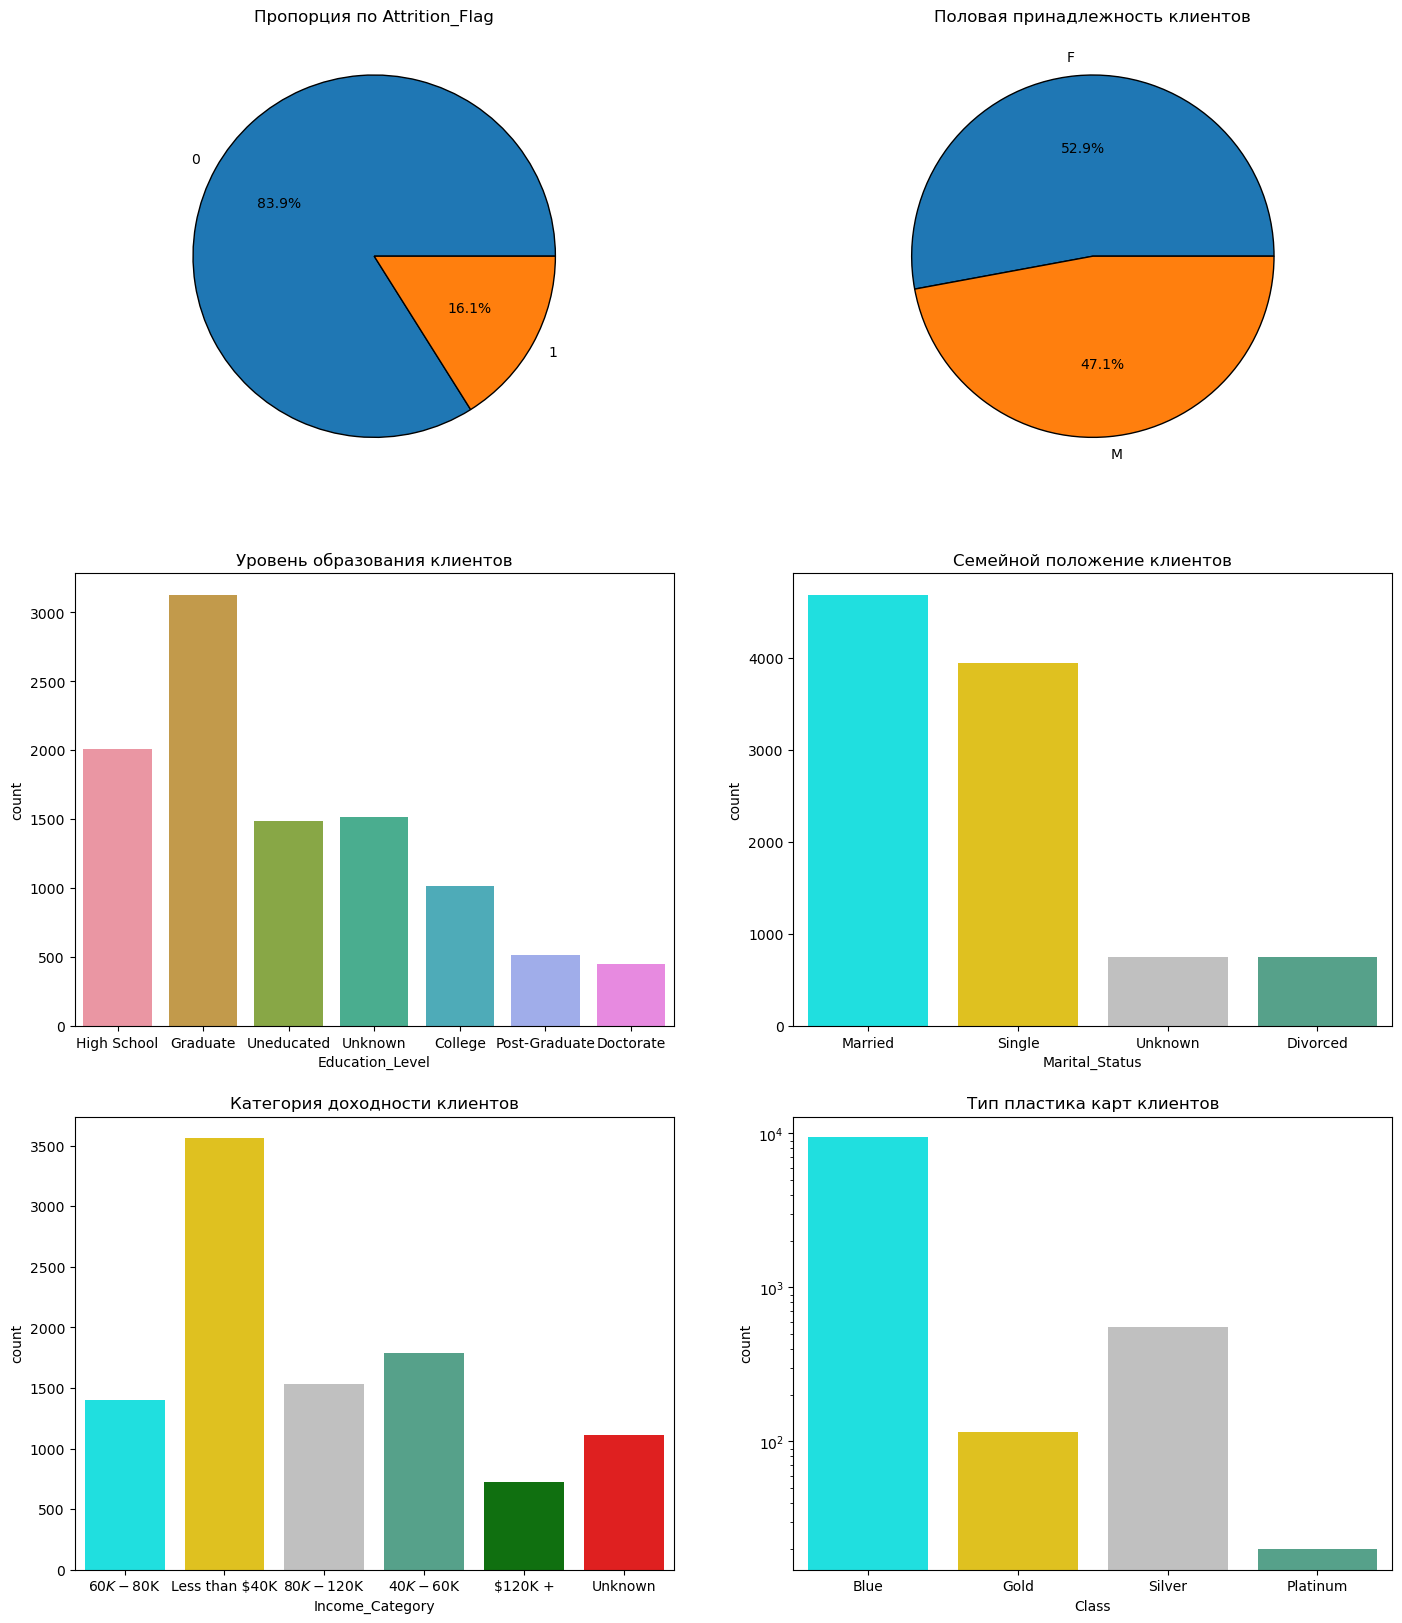

In [11]:
fig = plt.figure(constrained_layout=False, figsize=(17, 20))
spec = gridspec.GridSpec(ncols=2, nrows=3, figure = fig)
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[0, 1])
ax3 = fig.add_subplot(spec[1, 0])
ax4 = fig.add_subplot(spec[1, 1])
ax5 = fig.add_subplot(spec[2, 0])
ax6 = fig.add_subplot(spec[2, 1])

custom_palette = [ "aqua","gold","silver","#4AAD8F", "green", "red" ]
sns.set_palette(custom_palette)

# Смотрим соотношение активных и бывших клиентов
labels = df['Attrition_Flag'].value_counts().keys()
ax1.pie(df['Attrition_Flag'].value_counts(),labels = labels, autopct='%.1f%%', wedgeprops={'edgecolor': 'black'})
ax1.set_title('Пропорция по Attrition_Flag')

# Смотрим на половую принадлежность клиентов
labels = df['Gender'].value_counts().keys()
ax2.pie(df['Gender'].value_counts(),labels = labels, autopct='%.1f%%', wedgeprops={'edgecolor': 'black'})
ax2.set_title('Половая принадлежность клиентов')

# Смотрим на половую принадлежность клиентов
sns.countplot(ax=ax3, x=df['Education_Level'])
ax3.set_title('Уровень образования клиентов')

# Marital_Status 
sns.countplot(ax=ax4, x=df['Marital_Status'])
ax4.set_title('Семейной положение клиентов')

# Income_Category 
sns.countplot(ax=ax5, x=df['Income_Category'])
ax5.set_title('Категория доходности клиентов')              

# Card_Category
g = sns.countplot(ax=ax6, x=df['Card_Category'])
g.set_yscale("log")
_ = g.set(xlabel="Class", ylabel="count")
ax6.set_title('Тип пластика карт клиентов')

Из представленных выше графиков мы видим, что ушедших клиентов всего 16.1% от общей суммы, женщин больше всего на 2%, про большинство клиентов известно, что они или женаты, или холосты, а также что основная масса клиентов имеет
доходность ниже $40К.
Подавляющее большинство клиентов имеют голубую карту, поэтому на эту метрику мы более не смотрим.

<AxesSubplot:xlabel='Income_Category', ylabel='Avg_Utilization_Ratio'>

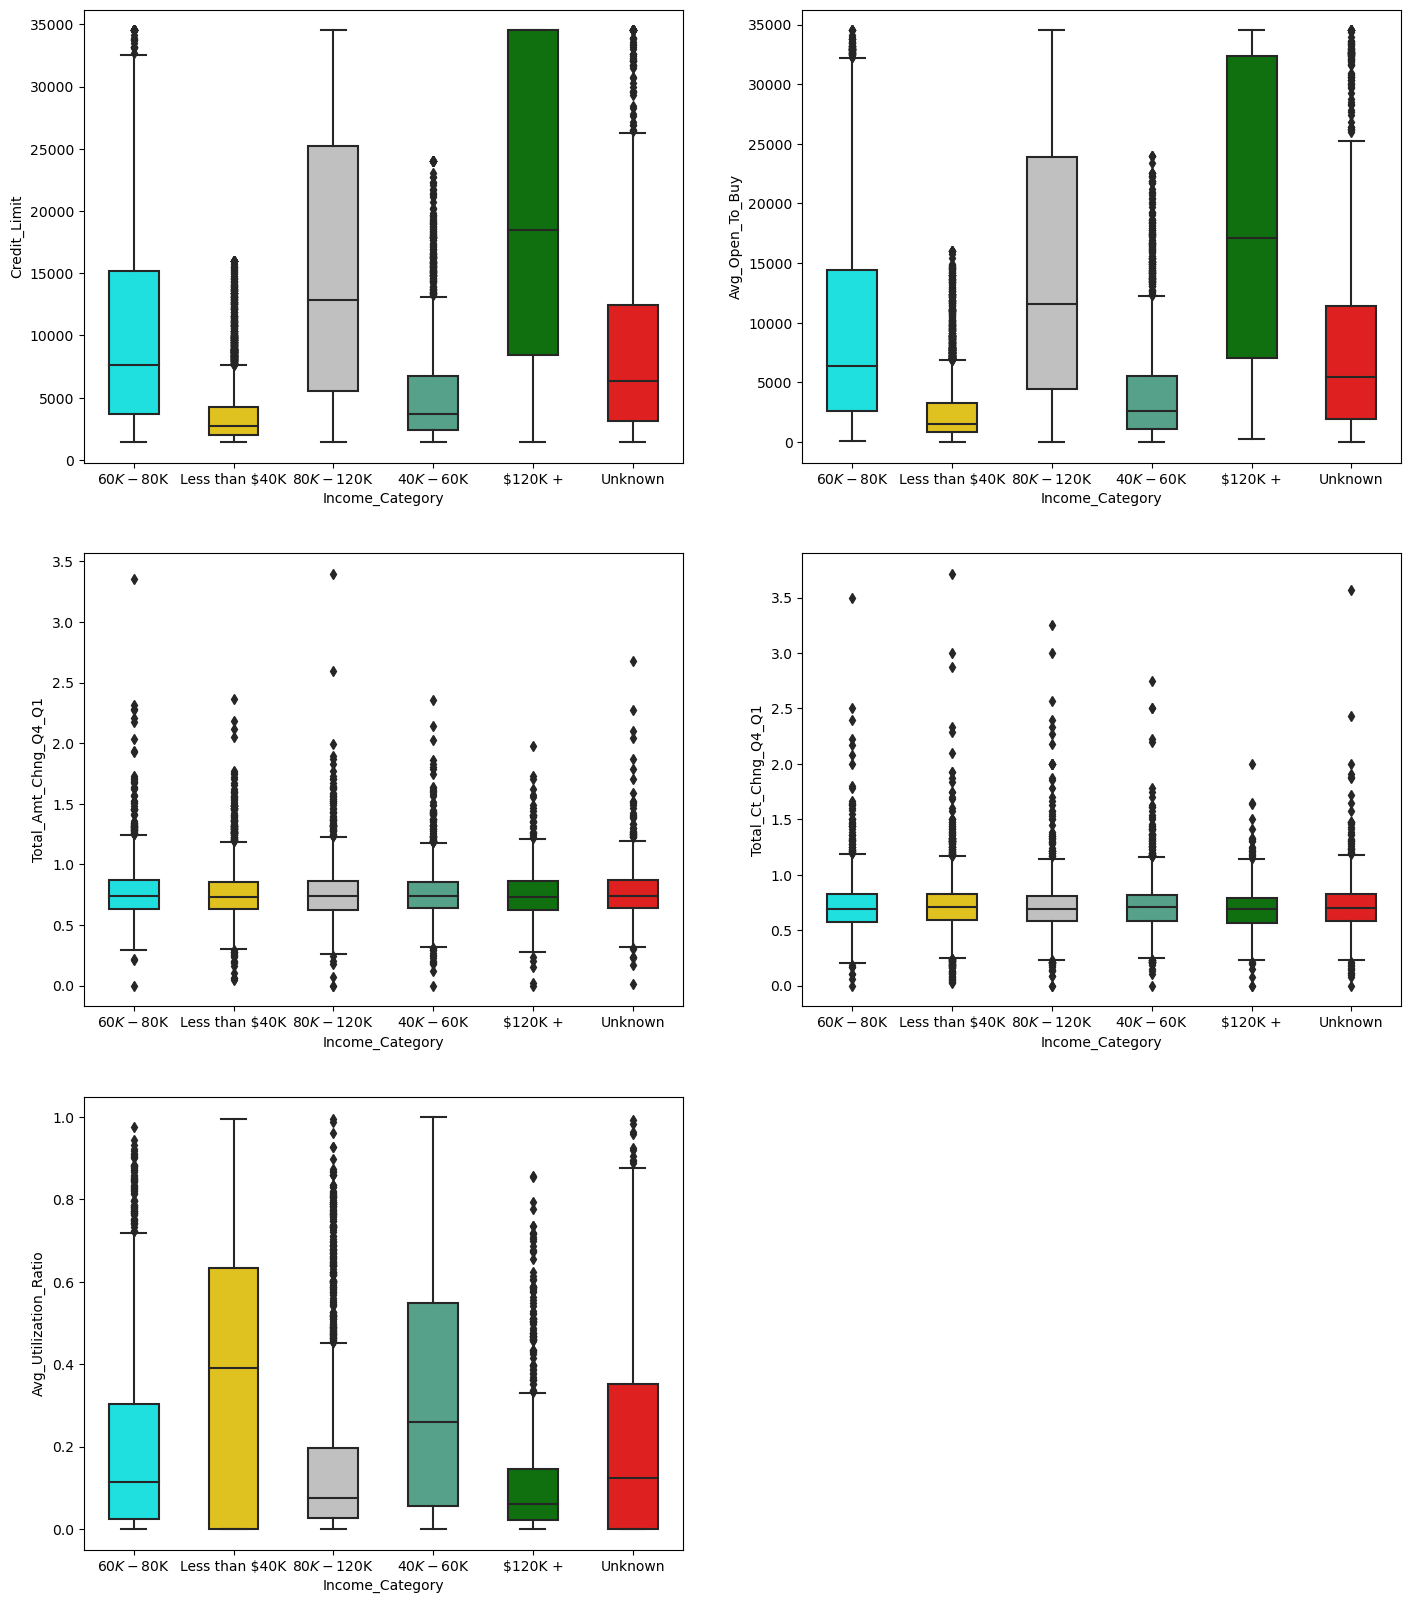

In [12]:
fig = plt.figure(figsize=(17, 20))
spec = gridspec.GridSpec(ncols=2, nrows=3, figure=fig)
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[0, 1])
ax3 = fig.add_subplot(spec[1, 0])
ax4 = fig.add_subplot(spec[1, 1])
ax5 = fig.add_subplot(spec[2, 0])

# Взаимосвязь дохода и кредитного лимита
sns.boxplot(data=df,y='Credit_Limit', x='Income_Category', width=0.5, ax=ax1)
# Взаимосвязь дохода и среднего кол-ва собственных средств
sns.boxplot(data=df,y='Avg_Open_To_Buy', x='Income_Category', width=0.5, ax=ax2)
# Взаимосвязь дохода и общей потраченной суммы
sns.boxplot(data=df,y='Total_Amt_Chng_Q4_Q1',x='Income_Category', width=0.5,ax=ax3)
# Взаимосвязь дохода и общего кол-ва покупок
sns.boxplot(data=df, y='Total_Ct_Chng_Q4_Q1', x='Income_Category', width=0.5,ax=ax4)
# Взаимосвязь дохода и процента утилизации
sns.boxplot(data=df,y='Avg_Utilization_Ratio', x='Income_Category', width=0.5, ax=ax5)

Мы видим, что у людей, с наиболее низким уровнем дохода слишком высокий кредит в сравнении со средним. Обратную ситуацию наблюдаем среди тех, чей доход $80К+. Также у последней категории клиентов больше всего собственных средств на карте.
Кредитный лимит прямо пропорционален доходу.

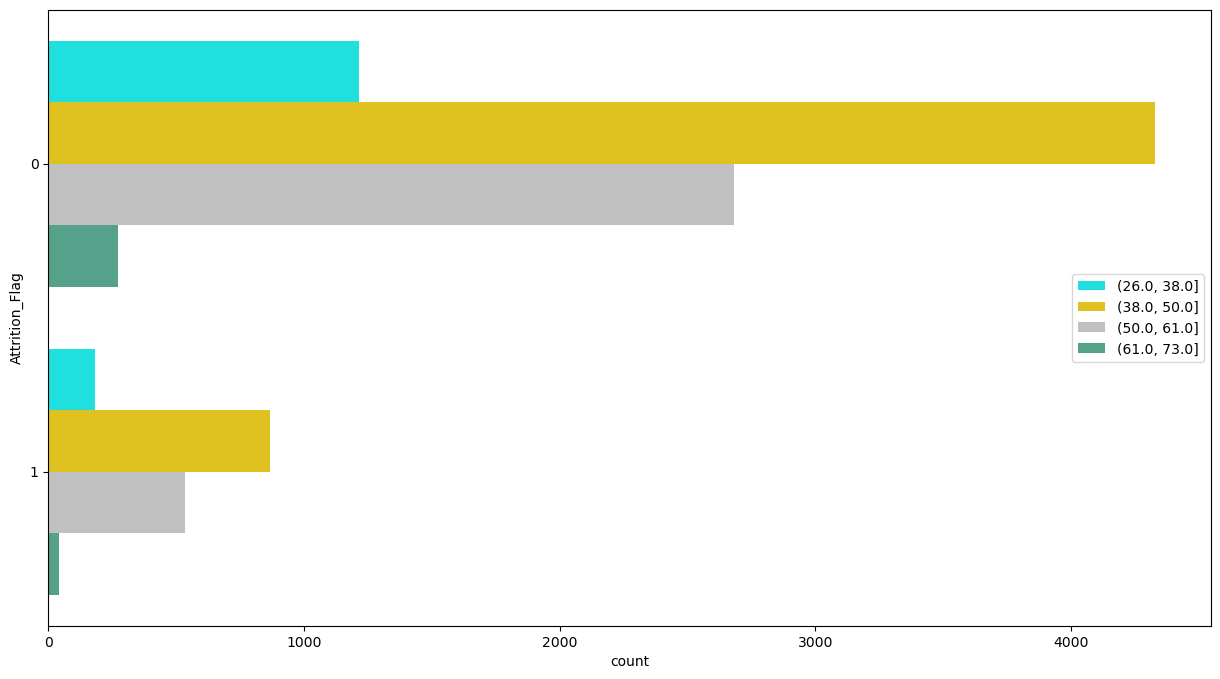

In [13]:
# Делим возраст клиента на 4 выборки
df['Customer_Age_Categorized'] = pd.cut(df['Customer_Age'], bins=4, precision=0)
plt.figure(figsize=(15,8))
sns.countplot(y='Attrition_Flag', hue='Customer_Age_Categorized', data = df)
plt.legend(loc = 'center right')

Мы видим, что среди клиентов, как активных, так и бывших, больше всего находятся в возрасте от 38 до 50 лет. На втором месте от 50 до 61, далее от 26 до 38, а меньше всего клиентов в возрасте от 61 до 73.

Attrition_Flag  Income_Category
0               Less than $40K     2949
                $40K - $60K        1519
                $80K - $120K       1293
                $60K - $80K        1213
                Unknown             925
                $120K +             601
1               Less than $40K      612
                $40K - $60K         271
                $80K - $120K        242
                $60K - $80K         189
                Unknown             187
                $120K +             126
Name: Income_Category, dtype: int64

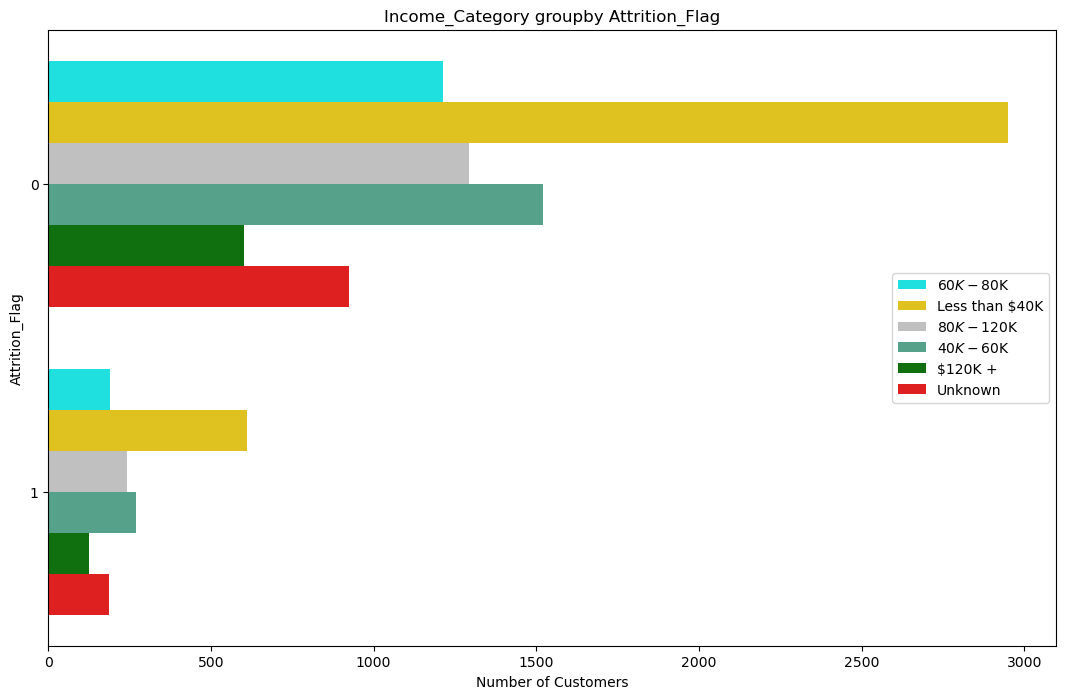

In [14]:
# Смотрим на категории дохода активных и бывших клиентов
plt.figure(figsize=(13,8))
sns.countplot(y='Attrition_Flag', hue='Income_Category', data = df)
plt.legend(loc = 'center right')
plt.xlabel('Number of Customers')
plt.ylabel('Attrition_Flag')
plt.title('Income_Category groupby Attrition_Flag')

df.groupby('Attrition_Flag')['Income_Category'].value_counts()

Мы снова наблюдаем паттерн, в котором распределение метрики (в данном случае, доходность) идентична в пропорциях среди активных и бывших клиентов. Больше всгео клиентов с наименьшей доходностью. Меньше всего - с наивысшей. Что интересно, клиентов с заработком между 60К и 80К чуть меньше, чем тех, чей заработок между 80К и 120К

Customer_Age_Categorized  Income_Category
(26.0, 38.0]              Less than $40K      537
                          $40K - $60K         275
                          Unknown             179
                          $60K - $80K         178
                          $80K - $120K        161
                          $120K +              70
(38.0, 50.0]              Less than $40K     1768
                          $40K - $60K         943
                          $80K - $120K        833
                          $60K - $80K         805
                          Unknown             542
                          $120K +             306
(50.0, 61.0]              Less than $40K     1109
                          $80K - $120K        531
                          $40K - $60K         498
                          $60K - $80K         388
                          $120K +             350
                          Unknown             342
(61.0, 73.0]              Less than $40K      147
        

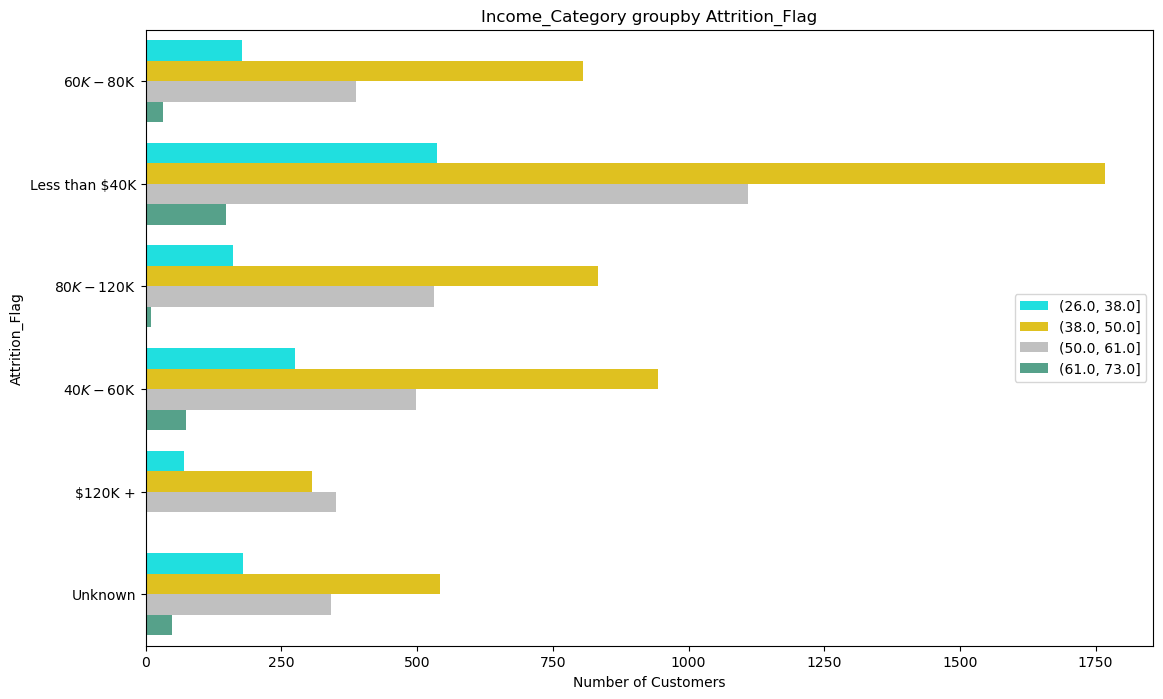

In [15]:
# Делаем разбивку по категории дохода среди бывших клиентов по возрастам в количественном соотношении
plt.figure(figsize=(13,8))
sns.countplot(y='Income_Category', hue='Customer_Age_Categorized', data = df)
plt.legend(loc = 'center right')
plt.xlabel('Number of Customers')
plt.ylabel('Attrition_Flag')
plt.title('Income_Category groupby Attrition_Flag')

df.groupby('Customer_Age_Categorized')['Income_Category'].value_counts()

В каждой категории доходности превалируют бывшие клиенты в возрасте от 38 до 50 лет. Исключением является доход $120К+, здесь больше всего клиентов в возрасте от 50 до 61 года. 

В каждой категории меньше всего клиентов в возрасте от 61 до 73 лет, а среди тех, кто зарабатывает $120К+, таких и вовсе нет, среди бывших клиентов.

In [16]:
# Группируем клиентов по семейному положению
df['Attrition_Flag'].value_counts(normalize=True)
df[['Attrition_Flag','Gender','Marital_Status']].groupby(['Gender','Marital_Status']).mean().round(2)

Attrition_Flag
Gender Marital_Status                
F      Divorced                  0.17
       Married                   0.17
       Single                    0.18
       Unknown                   0.18
M      Divorced                  0.15
       Married                   0.13
       Single                    0.16
       Unknown                   0.16

Исходя из полученных данных, мы видим, что самыми преданными/надежными клиентами являются женатые мужчины, а cамыми ненадёжными - одинокие женщины или женщины с неизвестным семейным положением. 
Можно предположить, что мужчины - более стабильные клиенты.

In [17]:
# Вычисляем средний возраст и среднее количество иждивенцев среди активных и бывших клиентов
df[['Attrition_Flag','Customer_Age','Dependent_count']].groupby(['Attrition_Flag']).mean().round(2)

,Customer_Age,Dependent_count
Attrition_Flag,,
0,46.26,2.34
1,46.66,2.40


Значения для активных и бывших клиентов отличаются не более, чем на 0,4. 

Из этого делаем вывод, что возраст и количество иждивенцев не являются признаком, по которому можно определить будущий статус клиента.

In [18]:
# Делаем разбивку бывших клиентов по месяцам неактивности и смотрим, 
# какой процент от всех клиентов они составляют в каждой категории
df[['Attrition_Flag','Months_Inactive_12_mon']].\
groupby(['Months_Inactive_12_mon']).agg(['mean','count']).round(2)

Attrition_Flag      
                                 mean count
Months_Inactive_12_mon                     
0                                0.52    29
1                                0.04  2233
2                                0.15  3282
3                                0.21  3846
4                                0.30   435
5                                0.18   178
6                                0.15   124

Мы видим, что чем больше месяцев прошло с момента последней активности, тем больший процент составляют такие клиенты.
Однако, в случаях, когда общее количество неактивных клиентов на промежутке неактивности слишком мало (<1000), эту гипотезу не представляется возможным подтвердить.

<AxesSubplot:>

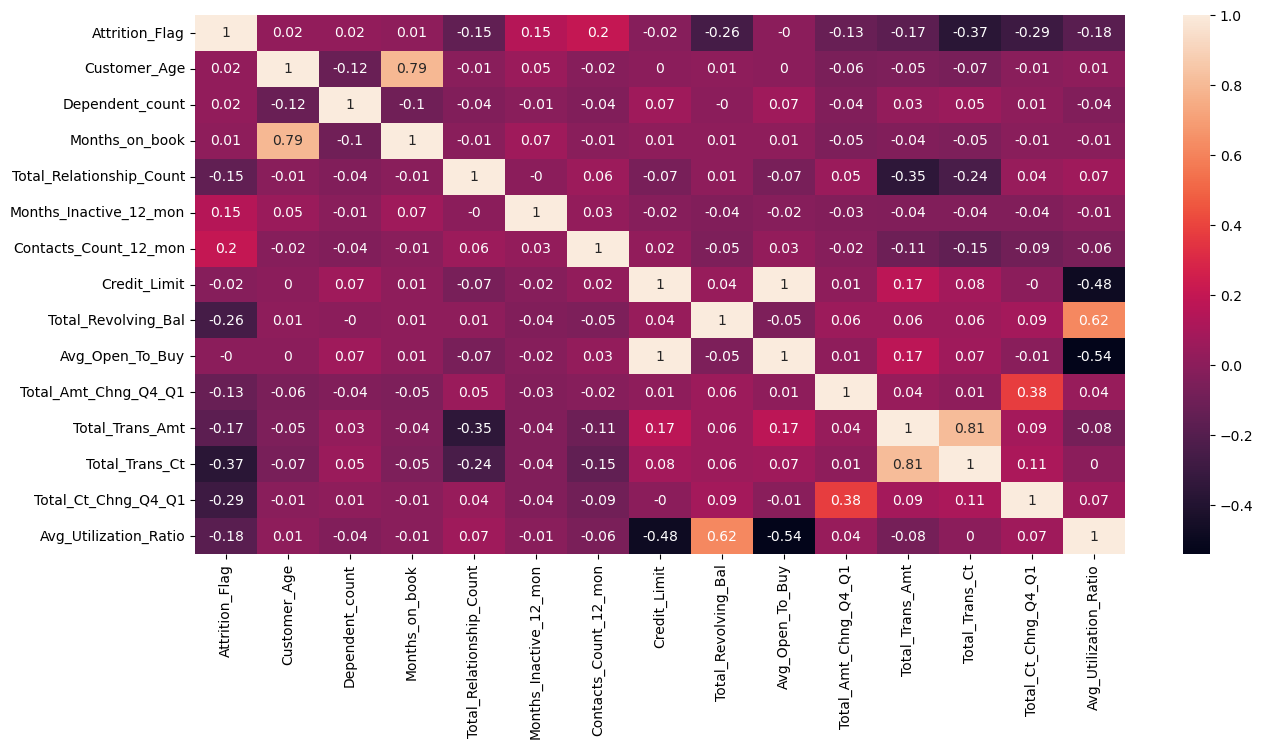

In [19]:
# Строим температурную карту корреляций, чтобы понять, какие показатели имеют наибольшее взаимное влияние
# Были проверены модели ‘pearson’, ‘kendall’, ‘spearman’, которые показали примерно одинаковый результат
corr = df.corr().round(2)
plt.figure(figsize=(15,7))
sns.heatmap(corr, annot=True)

In [20]:
abs(corr['Attrition_Flag']).sort_values(ascending = False)

Attrition_Flag              1.00
Total_Trans_Ct              0.37
Total_Ct_Chng_Q4_Q1         0.29
Total_Revolving_Bal         0.26
Contacts_Count_12_mon       0.20
Avg_Utilization_Ratio       0.18
Total_Trans_Amt             0.17
Total_Relationship_Count    0.15
Months_Inactive_12_mon      0.15
Total_Amt_Chng_Q4_Q1        0.13
Customer_Age                0.02
Dependent_count             0.02
Credit_Limit                0.02
Months_on_book              0.01
Avg_Open_To_Buy             0.00
Name: Attrition_Flag, dtype: float64

Мы видим, что больше всего на Attriction_Flag влияет общее количество транзакций (Total_Trans_Ct) и изменение количества транзакций (Total_Ct_Chng_Q4_Q1).

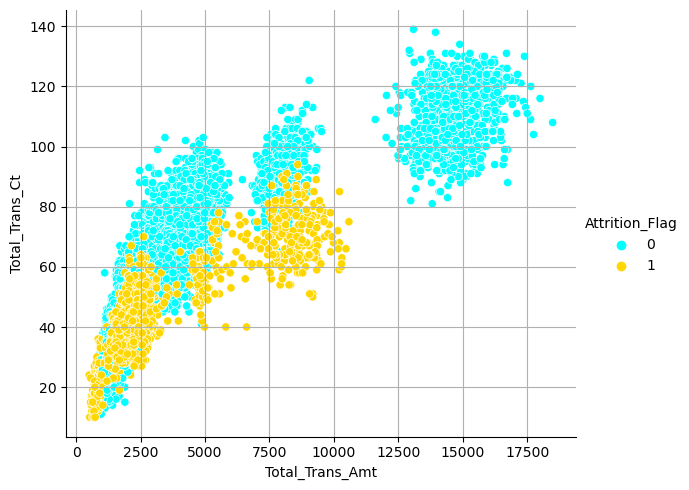

In [21]:
# Строим график взаимосвязи количества транзакций от суммы транзакций
sns.relplot(data=df, kind='scatter', x='Total_Trans_Amt', y='Total_Trans_Ct',hue='Attrition_Flag', height=5, aspect=1.2)
plt.grid()

Подытожим: если клиент совершил чуть больше 90 транзакций на сумму около 11000, его можно считать почти 100% надежным.